In [3]:
import polars as pl
import pandas as pd
import numpy as np
import csv 
from glob import glob
import os

from pathlib import Path
import pyarrow.parquet as pq

# parsed_dirs = [Path("/home/msalvetti/KOFScraper/chunks/run_id=2025-10-10/parsed")]
parsed_dirs = [Path("/home/msalvetti/KOFScraper/chunks/run_id=2025-12-19/parsed")]
corrupted = []

for d in parsed_dirs:
    for f in d.glob("*.parquet"):
        try:
            pq.read_table(f).schema  # just try to read schema
            # print(f"✅ OK:", f.name)
        except Exception as e:
            print(f"❌ Corrupted:", f.name, "|", e)
            corrupted.append(f)


all_files = [f for d in parsed_dirs for f in d.glob("*.parquet")]
files = [f for f in all_files if f not in corrupted]

lf = pl.scan_parquet(files).select(pl.col('ID', 'dl_rank', 'error', 'url', 'links'))

❌ Corrupted: ARGUS_chunk_p197.parquet | Error creating dataset. Could not read schema from '/home/msalvetti/KOFScraper/chunks/run_id=2025-12-19/parsed/ARGUS_chunk_p197.parquet'. Is this a 'parquet' file?: Could not open Parquet input source '/home/msalvetti/KOFScraper/chunks/run_id=2025-12-19/parsed/ARGUS_chunk_p197.parquet': Parquet magic bytes not found in footer. Either the file is corrupted or this is not a parquet file.
❌ Corrupted: ARGUS_chunk_p183.parquet | Error creating dataset. Could not read schema from '/home/msalvetti/KOFScraper/chunks/run_id=2025-12-19/parsed/ARGUS_chunk_p183.parquet'. Is this a 'parquet' file?: Could not open Parquet input source '/home/msalvetti/KOFScraper/chunks/run_id=2025-12-19/parsed/ARGUS_chunk_p183.parquet': Parquet magic bytes not found in footer. Either the file is corrupted or this is not a parquet file.


In [3]:
df = lf.filter(pl.col("error") == "None").collect()
names_df = pl.read_csv("nace-canton.csv").select("BVD", "Name")
df = df.join(names_df, left_on = "ID", right_on = "BVD")

In [4]:
df = df.with_columns(
    pl.col('url')
        .str.replace("https://", "")
        .str.replace("http://", "")
        .str.replace("www.", "")
        .str.replace(r'\/.*', '')
)

In [5]:
edgelist = (df
    .with_columns(
        pl.col("links")
            .cast(pl.Utf8)
            .str.replace_all(r'["\[\]]', '')
            .str.replace(r'^,\s*', '').fill_null("")
            .str.replace("https://", "")
            .str.replace("http://", "")
            .str.replace("www.", "")
            .str.replace(r'\/.*', '')
            .str.replace_all(r' ', '')
    )
    .with_columns(pl.col("links").str.split(","))
    .explode("links")
    .filter(pl.col("links") != "")
    .filter(pl.col("url") != "google.com")
    .filter(pl.col("url") != "accounts.google.com")
    .filter(pl.col("links").is_in(pl.col("url")))
    .unique()
    .join(df.select(["url", "Name"]).unique(),
         left_on = "links",
         right_on = "url",
         how = "left",
         suffix = "_dst")
    .with_columns(pl.col("Name_dst").alias("dst"))
    .drop("Name_dst")
    .with_columns(pl.col("Name").alias("src"))
).select(["src", "dst"])


/tmp/ipykernel_1964791/3740803805.py:18: DeprecationWarning: `is_in` with a collection of the same datatype is ambiguous and deprecated.
Please use `implode` to return to previous behavior.

See https://github.com/pola-rs/polars/issues/22149 for more information.
  .filter(pl.col("links").is_in(pl.col("url")))


In [6]:
edgelist.sample(fraction=0.5)

src,dst
str,str
"""WETTSTAI-CLIQUE""","""PULVER, METZGEREI UND SPEZIALI…"
"""BUCHER GROUP FINANCE AG""","""SWISSCANTO (CH) INDEX FUND V -…"
"""UP AG""","""MATTERHORN FLEISCH AG"""
"""TIFFANY HOTEL SA""","""ABCD CINE-DANCE S.A."""
"""RAIFFEISENBANK REGIO ARBON GEN…","""RAIFFEISENBANK UNTERE EMME GEN…"
…,…
"""AUSBILDUNGS- UND PRUEFUNGSBRAN…","""PRAGMA PARTENAIRES SA, SUCCURS…"
"""ZAUGG BAU AG THUN""","""RAIFFEISENBANK ZUERI-UNTERLAND…"
"""CHRISTOPH KOCH, HOFSTADL, GEMU…","""BOS SERVICE AG"""


In [ ]:
import networkx as nx
G = nx.from_pandas_edgelist(
    edgelist.sample(fraction = 0.1), source = "src", target = "dst", create_using = nx.DiGraph()
)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.2 MB/s eta 0:00:00:00:010:01


In [9]:
nx.write_gexf(G, "hyperlinks.gexf")

In [10]:
edgelist.group_by("dst").agg(pl.len()).unique("len").sort("len", descending=True).head(10)

dst,len
str,u32
"""PULVER, METZGEREI UND SPEZIALI…",537265
"""ASSOCIATION - LE COUCOU""",42472
"""MICROSOFT SCHWEIZ GMBH""",24461
"""RAIFFEISENBANK MISCHABEL-MATTE…",10460
"""RAIFFEISENBANK REGIO ARBON GEN…",10360
"""RAIFFEISENBANK NIDWALDEN GENOS…",10260
"""RAIFFEISENBANK MUOTATHAL GENOS…",10233
"""RAIFFEISENBANK ETTISWIL GENOSS…",10210
"""UNTERSTUETZUNGSFONDS DER JVA P…",9754


In [11]:
edges

NameError: name 'edges' is not defined

In [31]:
import networkx as nx
G = nx.from_pandas_edgelist(
    edges, source = "src", target = "dst", create_using = nx.DiGraph()
)

In [32]:
rank = edges.groupby("dst").count().sort_values("src", ascending = False).compute()

AttributeError: 'DataFrame' object has no attribute 'compute'

In [27]:
nx.write_gexf(G, "hyperlinks.gexf")

In [10]:
edges["dst"] = edges["dst"].map(lambda x: mapping.get(x, x))
edges["src"] = edges["src"].map(lambda x: mapping.get(x, x))


In [11]:
src = set(edges["src"])
dst = set(edges["dst"])

intersection = set.intersection(src, dst)

In [12]:
induced_graph = edges[edges['dst'].isin(intersection)]

In [94]:
induced_graph.to_csv("edges.csv")

In [14]:
import networkx as nx

G = nx.from_pandas_edgelist(
    induced_graph, source = "src", target = "dst", create_using = nx.DiGraph()
)

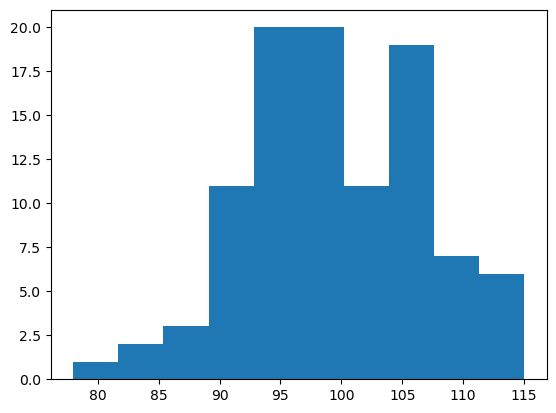

In [15]:
import matplotlib.pyplot as plt

def plot_degree_dist(G):
    degrees = [G.degree(n) for n in G.nodes()]
    plt.hist(degrees)
    plt.title("")
    plt.show()

plot_degree_dist(nx.gnp_random_graph(100, 0.5, directed = True))

In [90]:
nx.write_gexf(G, "hyperlinks.gexf")

In [96]:
induced_graph.groupby("dst").size().sort_values(ascending = False).head(20)

dst
JULES BACHMANN IMMOBILIEN AG                                                                           1265
RINGIER ART AG                                                                                          195
PRONOVO AG                                                                                               91
SIKA INFORMATIONSSYSTEME AG                                                                              58
TVO AG                                                                                                   54
FONDATION DU CENTRE SOCIAL PROTESTANT NEUCHATEL, CSP                                                     48
MITTELLAND MOLKEREI AG                                                                                   45
RCR PUBLICITE SA                                                                                         42
STIFTUNG EINSATZKOSTENVERSICHERUNG DER GEMEINDEN IN AUSSERORDENTLICHEN LAGEN                             42
FONDATION DE LA CAISSE D

# Better

In [4]:
df = lf.filter(pl.col("error") == "None").collect()
names_df = pl.read_csv("nace-canton.csv").select("BVD", "Name")
df = df.join(names_df, left_on = "ID", right_on = "BVD")
df

ID,dl_rank,error,url,links,Name
str,i64,str,str,str,str
"""CHCHE102764474""",0,"""None""","""https://wistra.ch""","""[""""]""","""WISTRA AG"""
"""CHCHE113234944""",0,"""None""","""https://sitterwerk.ch""","""["""", ""sitterwerk-katalog.ch""]""","""STIFTUNG SITTERWERK"""
"""CHCHE105765642""",0,"""None""","""https://valsernaturstein.ch""","""[""""]""","""VALSER NATURSTEIN AG STEINBRUC…"
"""CHCHE356356226""",0,"""None""","""https://miscommodities.com""","""[""""]""","""M.I.S. COMMODITIES AG"""
"""CHCHE109389638""",0,"""None""","""https://4pl.ch""","""[""""]""","""4PL LOGISTICS MANAGEMENT AG"""
…,…,…,…,…,…
"""CHCHE485410414""",29,"""None""","""https://www.pension-heino.ch/f…","""["""", ""saas-fee.ch"", ""twitter.c…","""CHIARA ANDENMATTEN"""
"""CHCHE485410414""",30,"""None""","""https://www.pension-heino.ch/e…","""["""", ""saas-fee.ch"", ""twitter.c…","""CHIARA ANDENMATTEN"""
"""CHCHE485410414""",30,"""None""","""https://www.pension-heino.ch/e…","""["""", ""saas-fee.ch"", ""twitter.c…","""CHIARA ANDENMATTEN"""


In [5]:
df = (df.with_columns(
    pl.col('url')
        .str.replace("https://", "")
        .str.replace("http://", "")
        .str.replace("www.", "")
        .str.replace(r'\/.*', '')
        )
.group_by("ID").agg(
    pl.col("url").first(),
    pl.col("links").str.join(",").str.split(","),
    pl.col("Name").first()
).explode("links").with_columns(
    pl.col("links").str.replace_all(r'[ \[\]"]', "")
))

In [6]:
edgelist = (df
    .with_columns(
        pl.col("links")
            .cast(pl.Utf8)
            .str.replace_all(r'["\[\]]', '')
            .str.replace(r'^,\s*', '').fill_null("")
            .str.replace("https://", "")
            .str.replace("http://", "")
            .str.replace("www.", "")
            .str.replace(r'\/.*', '')
            .str.replace_all(r' ', '')
    )
    .with_columns(pl.col("links").str.split(","))
    .explode("links")
    .filter(pl.col("links") != "")
    .filter(pl.col("url") != "google.com")
    .filter(pl.col("url") != "accounts.google.com")
    .filter(pl.col("links").is_in(pl.col("url")))
    .unique()
    .join(df.select(["url", "Name"]).unique(),
         left_on = "links",
         right_on = "url",
         how = "left",
         suffix = "_dst")
    .with_columns(pl.col("Name_dst").alias("dst"))
    .drop("Name_dst")
    .with_columns(pl.col("Name").alias("src"))
).select(["src", "dst"])


/tmp/ipykernel_11901/3740803805.py:18: DeprecationWarning: `is_in` with a collection of the same datatype is ambiguous and deprecated.
Please use `implode` to return to previous behavior.

See https://github.com/pola-rs/polars/issues/22149 for more information.
  .filter(pl.col("links").is_in(pl.col("url")))


In [7]:
import networkx as nx
G = nx.from_pandas_edgelist(
    edgelist.sample(fraction = 0.1), source = "src", target = "dst", create_using = nx.DiGraph()
)
nx.write_gexf(G, "hyperlinks.gexf")

In [8]:
edgelist.group_by("dst").agg(pl.len()).unique("len").sort("len", descending=True).rename({"dst": "Company mentioned", "len": "Number of mentions"}).head(10)

Company mentioned,Number of mentions
str,u32
"""MAGNETO MECCANICO MOTORCYCLES …",13875
"""ANDERMATT SWISS WATCHES AG""",12210
"""ASSOCIATION - LE COUCOU""",925
"""MICROSOFT SCHWEIZ GMBH""",581
"""BANQUE RAIFFEISEN DE GIMEL SOC…",256
"""BOS SERVICE AG""",252
"""UNTERSTUETZUNGSFONDS DER JVA P…",237
"""HEALTH INFO NET AG""",194
"""UBS CLEAN ENERGY INFRASTRUCTUR…",192


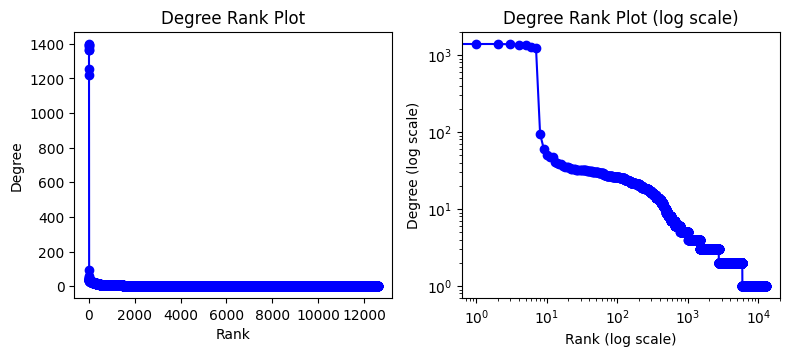

In [9]:
import matplotlib.pyplot as plt
import numpy as np

degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
dmax = max(degree_sequence)

fig = plt.figure("Degree of a random graph", figsize=(8, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)

ax1 = fig.add_subplot(axgrid[3:, :2])
ax1.plot(degree_sequence, "b-", marker="o")
ax1.set_title("Degree Rank Plot")
ax1.set_ylabel("Degree")
ax1.set_xlabel("Rank")
# ax1.set_xscale("log")
# ax1.set_yscale("log")

ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.plot(degree_sequence, "b-", marker="o")
ax2.set_title("Degree Rank Plot (log scale)")
ax2.set_ylabel("Degree (log scale)")
ax2.set_xlabel("Rank (log scale)")
ax2.set_xscale("log")
ax2.set_yscale("log")

fig.tight_layout()
plt.show()

In [33]:
edgelist

src,dst
str,str
"""WINDEX AG""","""INOCARE AG"""
"""WINDEX AG""","""PONTENOVA AG"""
"""PLASMA YOGA GMBH""","""CRESTA PALACE CELERINA AG"""
"""BUCHER INDUSTRIES AG""","""KEPLER SERVICES SA"""
"""EZO EISSPORTZENTRUM OBERTHURGA…","""GNG AG"""
…,…
"""VEREIN KLOSTER ST. SCHOLASTIKA…","""MAGNETO MECCANICO MOTORCYCLES …"
"""VEREIN KLOSTER ST. SCHOLASTIKA…","""PASI SA"""
"""VEREIN KLOSTER ST. SCHOLASTIKA…","""MATTERHORN FLEISCH AG"""
